In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy as sp
import scipy.stats as stats

In [2]:
data = pd.read_csv('medical_insurance.csv')

In [3]:
data.shape                   # data consists of 1338 entries 

(1338, 7)

In [4]:
data.head()                  # 3 categorical regressor variables

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
data.info()            # No missing values encountereed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


As observed, there might exist outliers in the BMI and CHARGES features 

In [7]:
data.duplicated().sum()

1

In [8]:
print(data.duplicated().sum())

1


In [9]:
data.corr()

C:\Users\bitha\AppData\Local\Temp\ipykernel_5280\2627137660.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


In [10]:
data.tail()

,age,sex,bmi,children,smoker,region,charges
1333,50,male,30.97,3,no,northwest,10600.5483
1334,18,female,31.92,0,no,northeast,2205.9808
1335,18,female,36.85,0,no,southeast,1629.8335
1336,21,female,25.80,0,no,southwest,2007.9450
1337,61,female,29.07,0,yes,northwest,29141.3603


# Exploratory Data Analysis

## Univariate EDA 

In [11]:
feat_cat = data.select_dtypes(include = object).columns
feat_num = data.select_dtypes(exclude = object).columns
feat_cat, feat_num

(Index(['sex', 'smoker', 'region'], dtype='object'),
 Index(['age', 'bmi', 'children', 'charges'], dtype='object'))

In [12]:
num_data = data[feat_num]
cat_data = data[feat_cat]

<Axes: xlabel='sex', ylabel='count'>

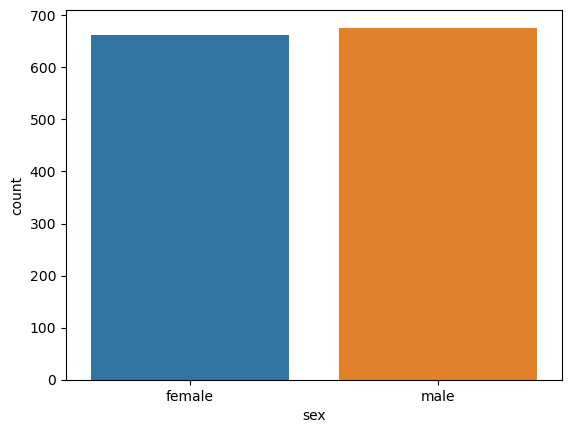

In [13]:
sns.countplot(x='sex', data=data)

There is almost equal representation among both males and females in the data.

<Axes: xlabel='smoker', ylabel='count'>

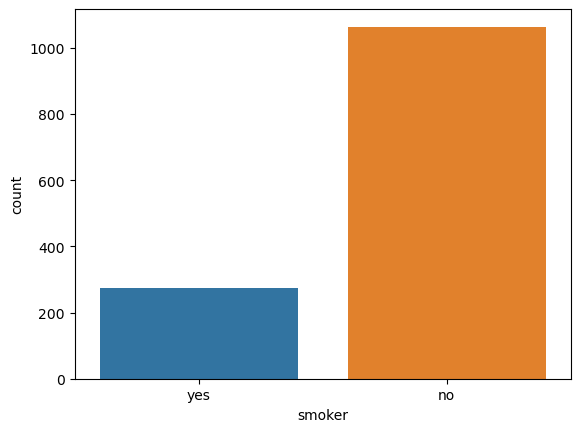

In [14]:
sns.countplot(x='smoker', data=data)

Only 20% of the people surveyed are smokers.

<Axes: xlabel='region', ylabel='count'>

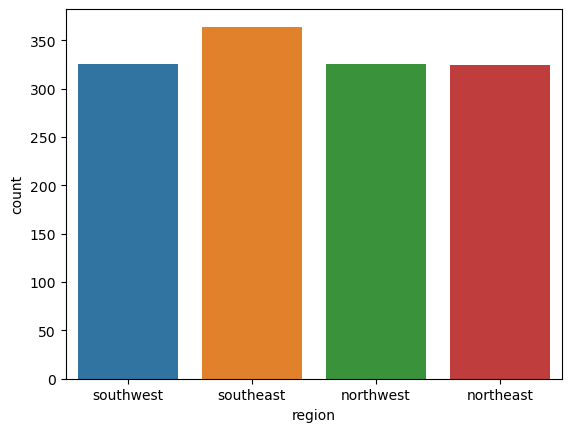

In [15]:
sns.countplot(x='region', data=data)

The people surveyed hail from all the regions almost uniformly

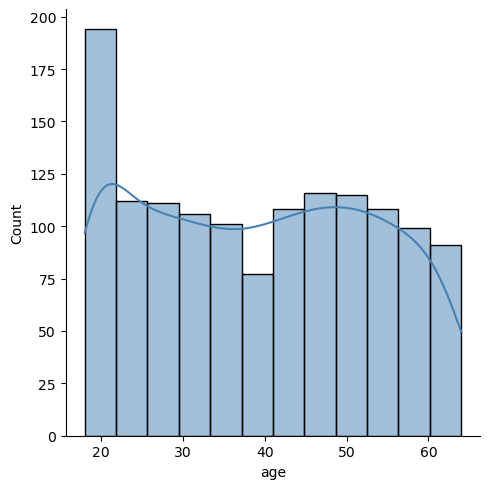

In [16]:
sns.displot(data['age'], color= ('steelblue'), kde=True)


There are comparitively many people around 20 years of age compared to other age groups.

<Axes: >

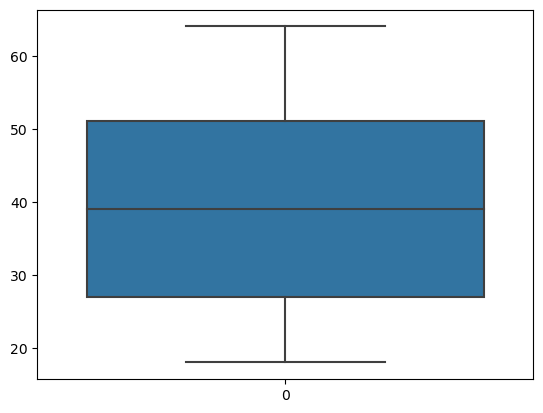

In [17]:
sns.boxplot(data['age'])

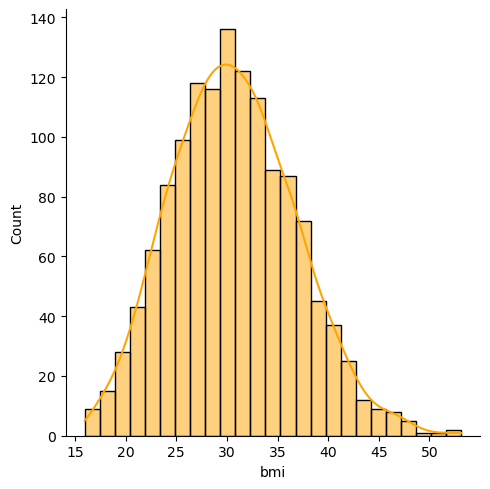

In [18]:
sns.displot(data['bmi'], color= ('orange'), kde=True) 
# sns.displot(data['bmi'], kind = 'kde', color= ('orange'))


<Axes: >

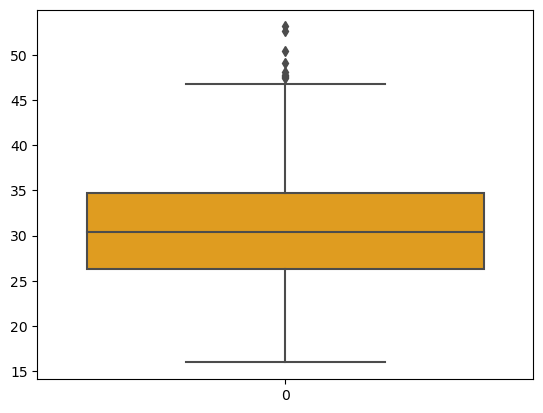

In [19]:
sns.boxplot(data['bmi'], color='orange')

The BMI of the surveyed individuals are approximately normally distributed. The BMI data had a few outliers that were capped to the upper bound.

<Axes: >

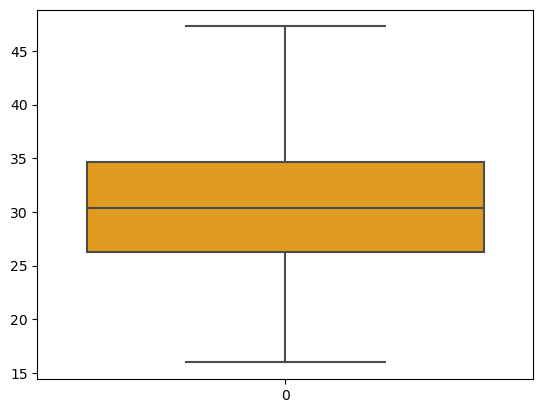

In [20]:
Q1 = data['bmi'].quantile(0.25)
Q3 = data['bmi'].quantile(0.75)
IQR = Q3-Q1

lb = Q1 - 1.5*IQR
ub = Q3 + 1.5*IQR

data['bmi'] = data['bmi'].apply(lambda x : lb if x<lb else x)
data['bmi'] = data['bmi'].apply(lambda x : ub if x>ub else x)

sns.boxplot(data['bmi'], color='orange')

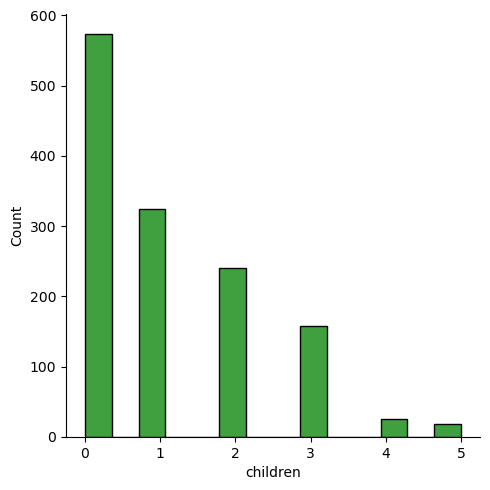

In [21]:
sns.displot(data['children'], color= ('green')) 
# sns.displot(data['children'], kind = 'kde', color= ('green')) 

There is a very high portion of individuals with no children and the number decreases with increase in number of children.

In [22]:
# sns.boxplot(data['children'], color='green')

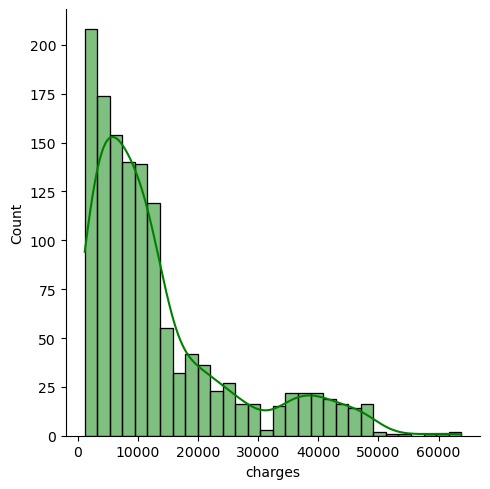

In [23]:
sns.displot(data['charges'], color= ('green'), kde=True) 
# sns.displot(data['charges'], kind = 'kde', color= ('green')) 

The response (output) variable ie. 'charges' is right-skewed and not normally distributed as need to be to satisfy the assumptions of linear regression. To ormalize the response variable we need to apply some appropriate transformation

## Bivariate EDA 

<Axes: xlabel='sex', ylabel='charges'>

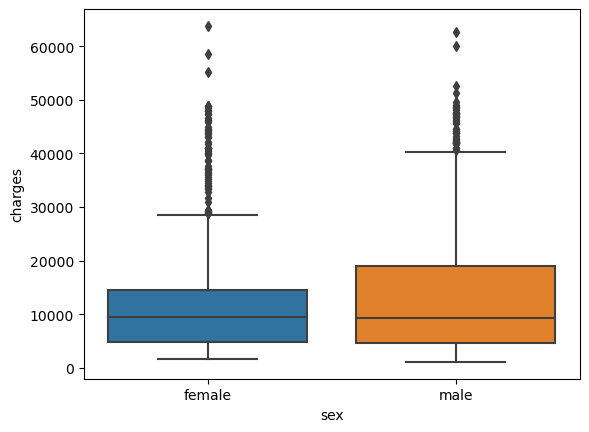

In [24]:
sns.boxplot(data, x='sex', y = 'charges')

<Axes: xlabel='smoker', ylabel='charges'>

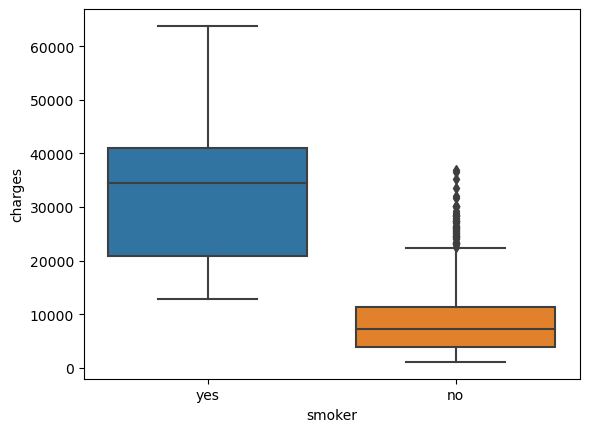

In [25]:
sns.boxplot(data, x='smoker', y = 'charges')

There exist some individuals who do not smoke but have comparitively higher insurance prices than majority of non-smokers.

<Axes: xlabel='region', ylabel='charges'>

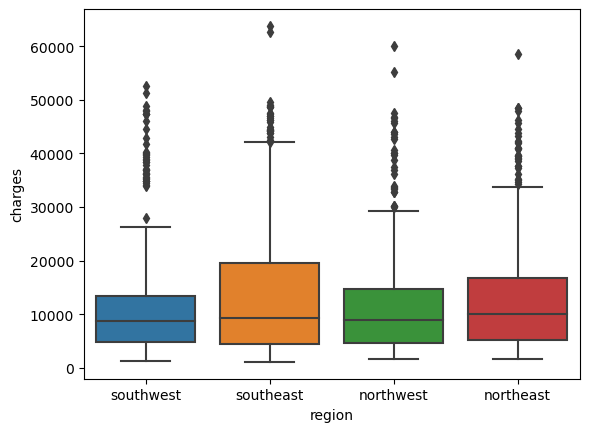

In [26]:
sns.boxplot(data, x='region', y='charges')

<Axes: xlabel='age', ylabel='charges'>

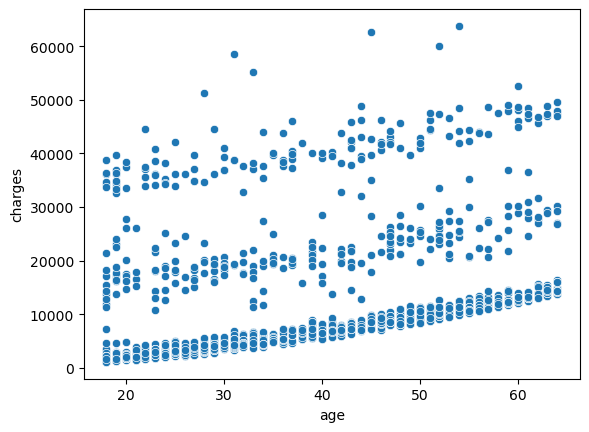

In [27]:
sns.scatterplot(data, x = 'age', y = 'charges') 

<Axes: xlabel='bmi', ylabel='charges'>

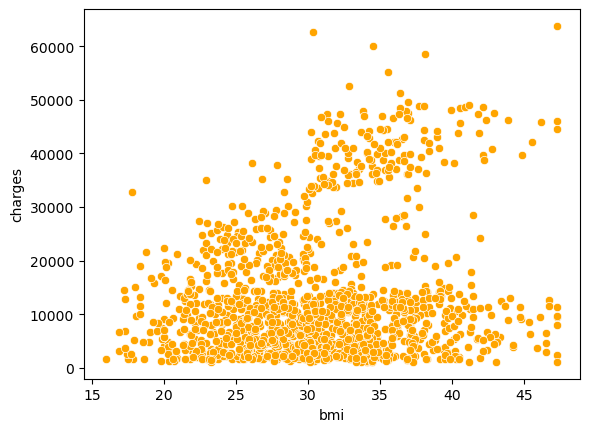

In [28]:
sns.scatterplot(data, x = 'bmi', y = 'charges', color='orange')

The people with high medical insurance costs have high BMI indicating obesity or an unhealthy lifestyle 

<Axes: xlabel='children', ylabel='charges'>

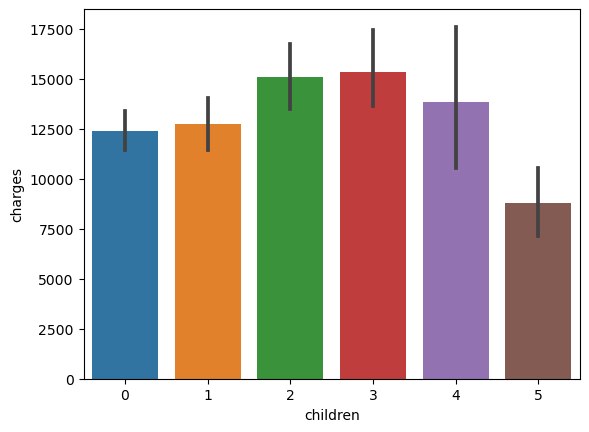

In [29]:
sns.barplot(data, x = 'children', y = 'charges')

Families with more than 2 children have pay higher prices of medical insurance. Surprisingly, families with 5 children pay lower insurance costs which can be due to financial instability and poor educational awareness. 

C:\Users\bitha\AppData\Local\Temp\ipykernel_5280\4069945627.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


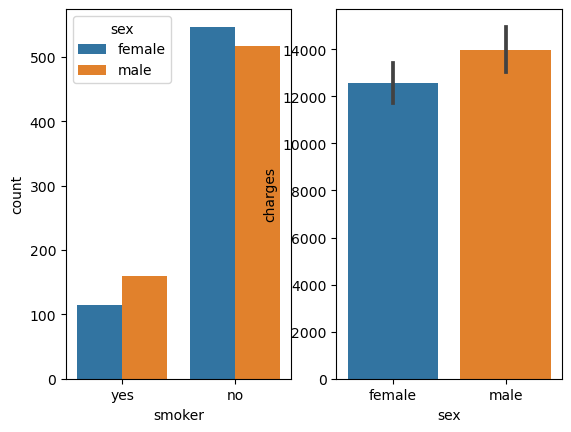

In [30]:
fig, ax = plt.subplots(1,2)

sns.countplot(data=data, x=data['smoker'], hue=data['sex'], ax=ax[0])
sns.barplot(data, x = 'sex', y = 'charges', ax = ax[1])
fig.show()

A higher proportion of the smokers are males and it can be observed that males pay higher prices of medical insurance 

<Axes: xlabel='children', ylabel='count'>

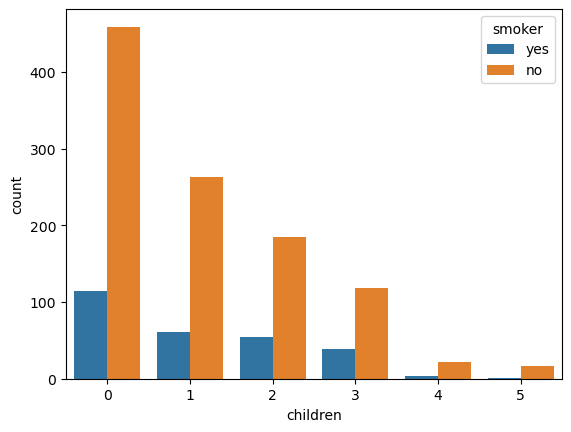

In [31]:
sns.countplot(data=data, x=data['children'], hue=data['smoker'])

charges     1.000000
age         0.299008
bmi         0.198341
children    0.067998
Name: charges, dtype: float64 



<Axes: >

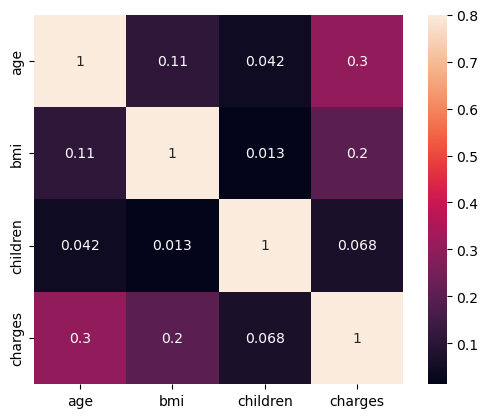

In [32]:
correlation = num_data.corr() 
print(correlation['charges'].sort_values(ascending=False),'\n')
sns.heatmap(correlation, square=True, vmax=0.8, annot=True)

There doesnt exist high correlation (> 0.9) between any of the numerical features. 

In [33]:
#sns.pairplot(data, hue="sex")

In [34]:
#sns.pairplot(data, hue="smoker")

In [35]:
#sns.pairplot(data, hue="region")

# One Hot Encoding

In [36]:
ohe_data = data

In [37]:
ohe_data['sex'] = ohe_data['sex'].astype('category')
ohe_data['smoker'] = ohe_data['smoker'].astype('category')
ohe_data['region'] = ohe_data['region'].astype('category')

In [38]:
ohe_data['sex_new'] = ohe_data['sex'].cat.codes
ohe_data['smoker_new'] = ohe_data['smoker'].cat.codes
ohe_data['region_new'] = ohe_data['region'].cat.codes

In [39]:
enc = OneHotEncoder(drop = 'first', dtype= 'int32')

enc_data = pd.DataFrame(enc.fit_transform(ohe_data[['sex_new', 'smoker_new', 'region_new']]).toarray())

new_data = ohe_data.join(enc_data)
print(new_data)

      age     sex     bmi  children smoker     region      charges  sex_new  \
0      19  female  27.900         0    yes  southwest  16884.92400        0   
1      18    male  33.770         1     no  southeast   1725.55230        1   
2      28    male  33.000         3     no  southeast   4449.46200        1   
3      33    male  22.705         0     no  northwest  21984.47061        1   
4      32    male  28.880         0     no  northwest   3866.85520        1   
...   ...     ...     ...       ...    ...        ...          ...      ...   
1333   50    male  30.970         3     no  northwest  10600.54830        1   
1334   18  female  31.920         0     no  northeast   2205.98080        0   
1335   18  female  36.850         0     no  southeast   1629.83350        0   
1336   21  female  25.800         0     no  southwest   2007.94500        0   
1337   61  female  29.070         0    yes  northwest  29141.36030        0   

      smoker_new  region_new  0  1  2  3  4  
0    

In [40]:
new_data = new_data.drop(['sex_new', 'smoker_new', 'region_new'], axis=1)

In [41]:
new_data.head()

,age,sex,bmi,children,smoker,region,charges,0,1,2,3,4
0,19,female,27.900,0,yes,southwest,16884.92400,0,1,0,0,1
1,18,male,33.770,1,no,southeast,1725.55230,1,0,0,1,0
2,28,male,33.000,3,no,southeast,4449.46200,1,0,0,1,0
3,33,male,22.705,0,no,northwest,21984.47061,1,0,1,0,0
4,32,male,28.880,0,no,northwest,3866.85520,1,0,1,0,0


In [42]:
new_data.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges', 0, 1, 2,
       3, 4],
      dtype='object')

In [43]:
new_data.columns = ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges', 'male', 'smokes', 'northwest',
       'southeast', 'southwest']

new_data.head()

,age,sex,bmi,children,smoker,region,charges,male,smokes,northwest,southeast,southwest
0,19,female,27.900,0,yes,southwest,16884.92400,0,1,0,0,1
1,18,male,33.770,1,no,southeast,1725.55230,1,0,0,1,0
2,28,male,33.000,3,no,southeast,4449.46200,1,0,0,1,0
3,33,male,22.705,0,no,northwest,21984.47061,1,0,1,0,0
4,32,male,28.880,0,no,northwest,3866.85520,1,0,1,0,0


In [44]:
df = new_data

In [45]:
df.head()

,age,sex,bmi,children,smoker,region,charges,male,smokes,northwest,southeast,southwest
0,19,female,27.900,0,yes,southwest,16884.92400,0,1,0,0,1
1,18,male,33.770,1,no,southeast,1725.55230,1,0,0,1,0
2,28,male,33.000,3,no,southeast,4449.46200,1,0,0,1,0
3,33,male,22.705,0,no,northwest,21984.47061,1,0,1,0,0
4,32,male,28.880,0,no,northwest,3866.85520,1,0,1,0,0


In [46]:
df = df.drop(['sex', 'smoker', 'region'], axis=1)

In [47]:
df.head()

,age,bmi,children,charges,male,smokes,northwest,southeast,southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0


In [48]:
data.head()

,age,sex,bmi,children,smoker,region,charges,sex_new,smoker_new,region_new
0,19,female,27.900,0,yes,southwest,16884.92400,0,1,3
1,18,male,33.770,1,no,southeast,1725.55230,1,0,2
2,28,male,33.000,3,no,southeast,4449.46200,1,0,2
3,33,male,22.705,0,no,northwest,21984.47061,1,0,1
4,32,male,28.880,0,no,northwest,3866.85520,1,0,1


In [49]:
data = data.drop(['sex_new','smoker_new','region_new'], axis=1)

In [50]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [51]:
data.shape

(1338, 7)

In [52]:
df.shape

(1338, 9)

In [53]:
# df = df.dropna()

# OLS Model Summary

In [54]:
X = df.drop(columns = 'charges', axis=1)
Y = df['charges']

In [55]:
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

In [56]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     501.1
Date:                Fri, 06 Oct 2023   Prob (F-statistic):               0.00
Time:                        15:01:43   Log-Likelihood:                -13547.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.201e+04    991.114    -12.116      0.000    -1.4e+04   -1.01e+04
age          256.4500     11.900     21.550      0.000     233.105     279.795
bmi          342.0877     28.786     11.884      0.000     285.617     398.559
children     474.0625    137.779      3.441      0.001     203.774     744.351
male        -125.4909    332.858     -0.377      0.706    -778.475     527.493
smokes      2.385e+04    413.077     57.738      0.000     2.3e+04    2.47e+04
northwest   -353.6507    476.185     -0.743      0.458   -1287.807     580.505
southeast  -1032.4729    478.493     -2.158      0.031   -1971.157     -93.789
southwest   -964.3940    477.866     -2.018      0.044   -1901.849     -26.939
==============================================================================
Omnibus:                      300.911   Durbin-Watson:                   2.087
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              719.878
Skew:                           1.214   Prob(JB):                    4.79e-157
Kurtosis:                       5.650   Cond. No.                         312.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

p-value of the variable 'male' = 0.70 > 0.05

# Influential Points by Cook's Distance

In [57]:
influence = model.get_influence()
cooks = influence.cooks_distance
print(cooks)

(array([2.03728234e-03, 5.14371699e-05, 9.95144919e-05, ...,
       1.29837605e-04, 1.11143625e-05, 1.91107415e-03]), array([1., 1., 1., ..., 1., 1., 1.]))


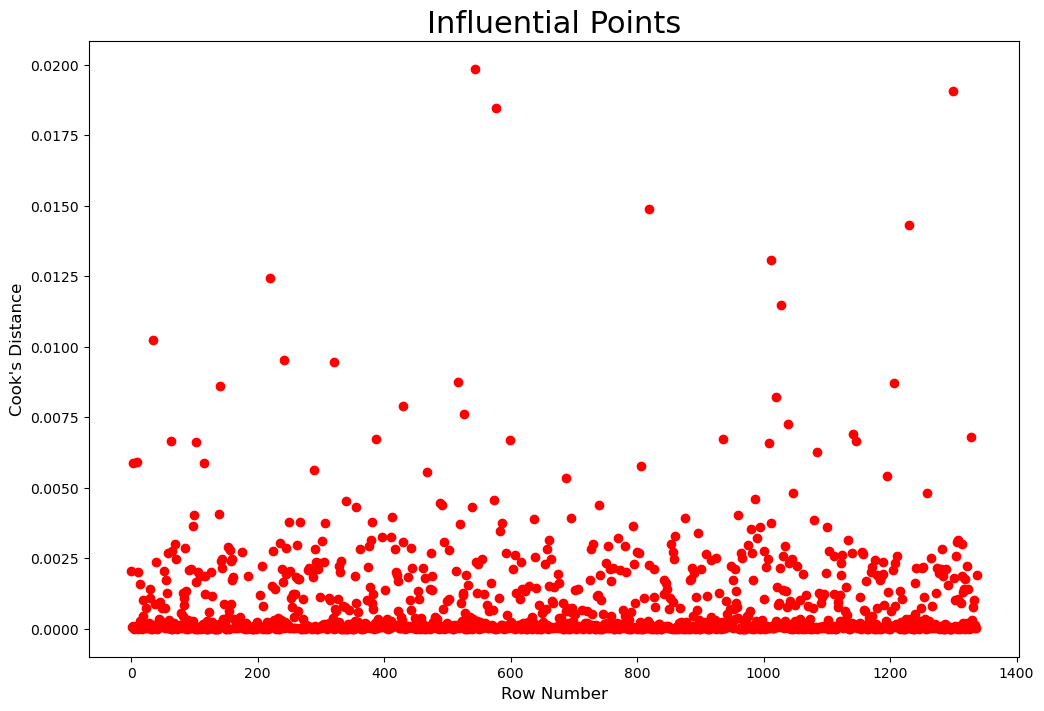

In [58]:
plt.figure(figsize = (12,8))
plt.scatter(df.index, cooks[0], color='red')
plt.xlabel('Row Number', fontsize=12)
plt.ylabel("Cook's Distance", fontsize=12)
plt.title("Influential Points", fontsize=22)
plt.show()


In [59]:
mean_cooks = np.mean(cooks[0])
mean_cooks

0.0008401437591185565

In [60]:
influential_points = df.index[cooks[0] > (4/1338)]
influential_points

Int64Index([   3,    9,   34,   62,   98,   99,  102,  115,  138,  140,  219,
             235,  242,  250,  266,  289,  301,  306,  321,  340,  355,  379,
             380,  387,  397,  411,  412,  429,  430,  468,  488,  491,  494,
             516,  520,  526,  539,  543,  573,  577,  583,  587,  599,  637,
             661,  688,  696,  730,  739,  770,  793,  806,  819,  854,  860,
             876,  896,  936,  959,  980,  987,  989,  994, 1008, 1011, 1012,
            1019, 1027, 1039, 1047, 1080, 1085, 1100, 1134, 1142, 1146, 1195,
            1206, 1230, 1258, 1300, 1306, 1307, 1328],
           dtype='int64')

In [61]:
df.iloc[influential_points, :]

,age,bmi,children,charges,male,smokes,northwest,southeast,southwest
3,33,22.705,0,21984.47061,1,0,1,0,0
9,60,25.840,0,28923.13692,0,0,1,0,0
34,28,36.400,1,51194.55914,1,1,0,0,1
62,64,24.700,1,30166.61817,1,0,1,0,0
98,56,19.950,0,22412.64850,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...
1258,55,37.715,3,30063.58055,1,0,1,0,0
1300,45,30.360,0,62592.87309,1,1,0,1,0
1306,29,21.850,0,16115.30450,0,1,0,0,0
1307,32,28.120,4,21472.47880,1,1,1,0,0


In [62]:
df = df.drop(influential_points)
df.head()

,age,bmi,children,charges,male,smokes,northwest,southeast,southwest
0,19,27.90,0,16884.9240,0,1,0,0,1
1,18,33.77,1,1725.5523,1,0,0,1,0
2,28,33.00,3,4449.4620,1,0,0,1,0
4,32,28.88,0,3866.8552,1,0,1,0,0
5,31,25.74,0,3756.6216,0,0,0,1,0


### Assumption 4 - Homoscedasticity 

In [63]:
# BP test for testing for homoscedasticity

X = df.drop(columns = 'charges', axis=1)
Y = df['charges']

X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()
model.summary()

_, bp_value, _, _ = sm.stats.diagnostic.het_breuschpagan(model.resid, X)
print(bp_value)

1.1348315529457864e-113


Since p value < 0.05, Ho is rejected, indicating evidence of heteroscedaticity (ie. the variance of the residuals is not constant)

# Fitting MLR model

In [64]:
X = df.drop(columns = 'charges', axis=1)
Y = df['charges']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [65]:
lr = LinearRegression()
model = lr.fit(X_train, Y_train)

In [66]:
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

In [67]:
residual = Y_train - Y_train_pred
print(model.coef_)

[  253.00065828   300.29902425   515.09219327   -72.67358277
 24793.90711566 -1130.955987   -1482.37444627 -1338.79064608]


In [68]:
print(model.intercept_)

-11099.743171489969


In [69]:
print("Training R^2 = ",r2_score(Y_train, Y_train_pred))
print("Testing R^2 = ",r2_score(Y_test, Y_test_pred))

Training R^2 =  0.8465612387927985
Testing R^2 =  0.848948329184047


### Assumption 2 -  Checking for multicollinearity

In [70]:
# VARIANCE INFLATION FACTOR
p = X_train.shape[1]
print(p)

vif = [variance_inflation_factor(X_train.values, i) for i in range(p)]
vif = pd.Series(vif, index = X_train.columns)
print(vif)

8
age           7.656877
bmi          11.377652
children      1.812741
male          2.041209
smokes        1.249298
northwest     1.886930
southeast     2.205887
southwest     1.987350
dtype: float64


VIF of 'age' feature is greater than 5 indicating possible existence of multicollinearity.
VIF of 'bmi' feature is greater that 10 indicating presence of significant multicollinearity that needs to be corrected.

charges     1.000000
age         0.313854
bmi         0.207754
children    0.062724
Name: charges, dtype: float64 



<Axes: >

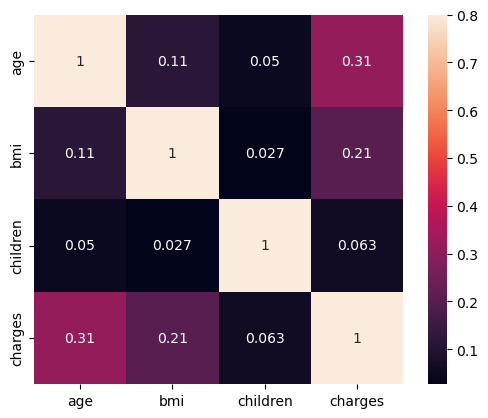

In [71]:
# CORRELATION HEATMAP
num_data = df[feat_num]
correlation = num_data.corr()
print(correlation['charges'].sort_values(ascending=False),'\n')
sns.heatmap(correlation, square=True, vmax=0.8, annot=True)

### Assumption 3 - Normality of residuals

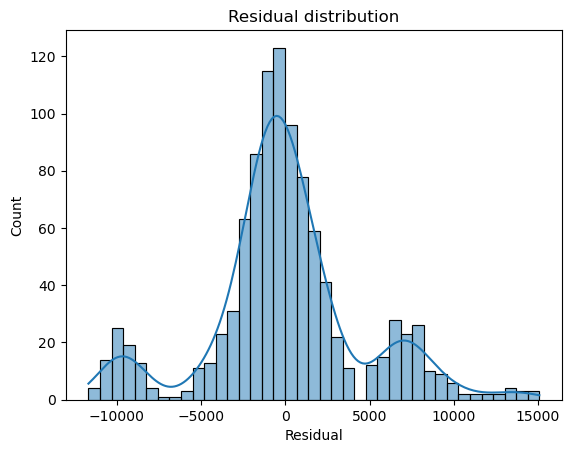

In [72]:
sns.histplot(residual, kde=True)
plt.xlabel("Residual")
plt.title("Residual distribution")
plt.show()

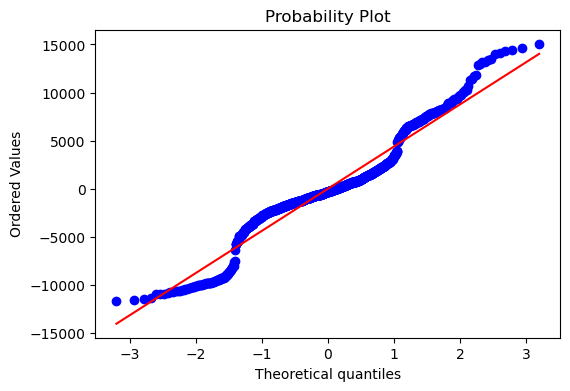

In [73]:
# QQ plot
fig, ax = plt.subplots(figsize=(6,4))
sp.stats.probplot(residual, plot=ax, fit=True)
plt.show()

In [74]:
# Shapiro-Wilk test for normality of residuals
statistic, p_value = sp.stats.shapiro(residual)
print(statistic, p_value)

0.9400090575218201 1.0752862640814338e-19


Since p value < 0.05, Ho is rejected, indicating residuals are not normally distributed

### Assumption 5 - Autocorrelation 

In [75]:
# Durbin Watson test for auto-correlation
durbin_watson_statistic = sm.stats.durbin_watson(residual)
print(durbin_watson_statistic)

2.0388885265927326


Since the Durbin-Watson statistic value is around 2, it indicates that there is no significant autocorrelation in the residuals.


## Residual Plots 

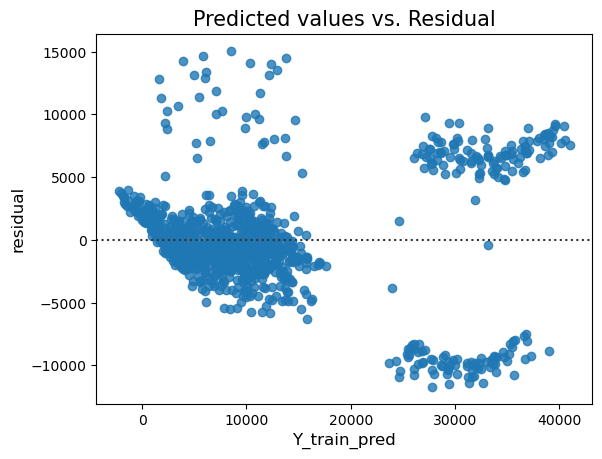

In [76]:
sns.residplot(x=Y_train_pred, y=residual)
plt.xlabel("Y_train_pred", fontsize = 12)
plt.ylabel("residual", fontsize = 12)
plt.title("Predicted values vs. Residual", fontsize=15)
plt.show()


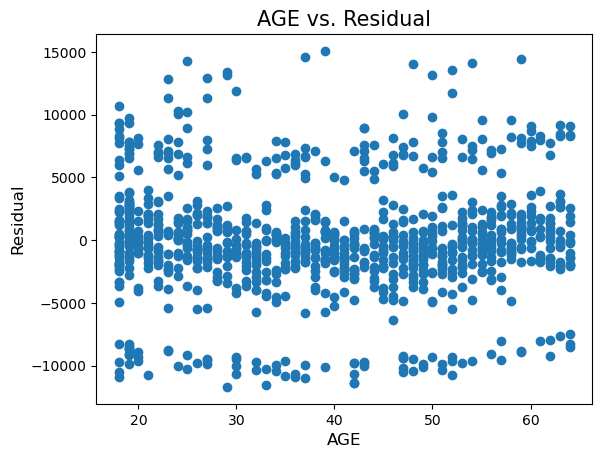

In [77]:
plt.scatter(X_train['age'], residual)
plt.xlabel("AGE", fontsize = 12)
plt.ylabel("Residual", fontsize = 12)
plt.title("AGE vs. Residual", fontsize=15)
plt.show()


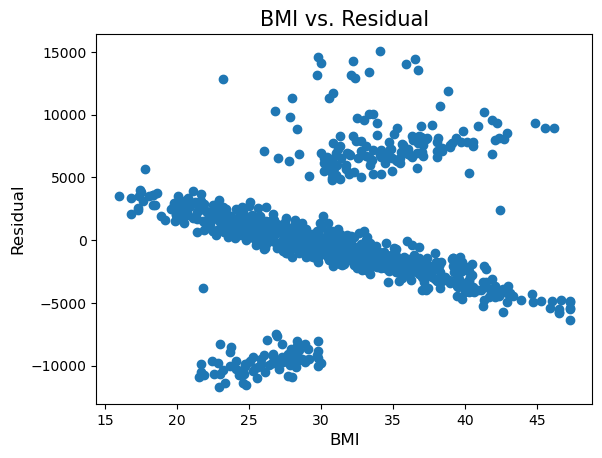

In [78]:
plt.scatter(X_train['bmi'], residual)
plt.xlabel("BMI", fontsize = 12)
plt.ylabel("Residual", fontsize = 12)
plt.title("BMI vs. Residual", fontsize=15)
plt.show()

In the BMI vs. Residual plot, the data points are observed to be forming clusters. S we check the BMI vs charges plot to get better understanding. 

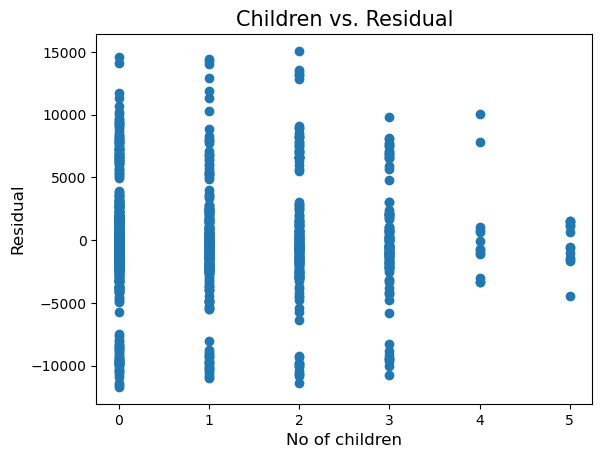

In [79]:
plt.scatter(X_train['children'], residual)
plt.xlabel("No of children", fontsize = 12)
plt.ylabel("Residual", fontsize = 12)
plt.title("Children vs. Residual", fontsize=15)
plt.show()


In [80]:
df.head()

,age,bmi,children,charges,male,smokes,northwest,southeast,southwest
0,19,27.90,0,16884.9240,0,1,0,0,1
1,18,33.77,1,1725.5523,1,0,0,1,0
2,28,33.00,3,4449.4620,1,0,0,1,0
4,32,28.88,0,3866.8552,1,0,1,0,0
5,31,25.74,0,3756.6216,0,0,0,1,0


In [81]:
SPL = df[df['smokes']==1]              # smoking 
NSPL = df[df['smokes']==0]             # non smokers


<Axes: xlabel='bmi', ylabel='charges'>

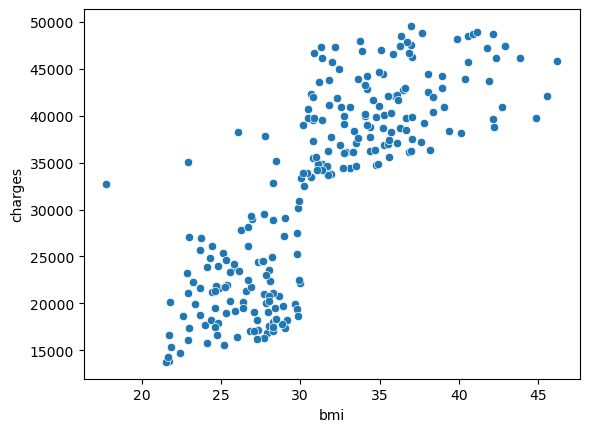

In [82]:
sns.scatterplot(SPL, x = 'bmi', y = 'charges')

<Axes: xlabel='bmi', ylabel='charges'>

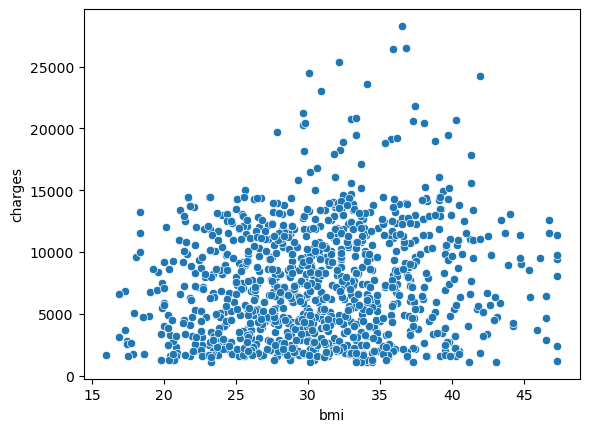

In [83]:
sns.scatterplot(NSPL, x = 'bmi', y = 'charges')

As seen from the above two scatter plots of BMI (grouped into smoker and non-smoker) vs charges, we observed that there are 2 clusters (BMI<30, BMI>30) being formed in the smoker group of people. And non smokers are distributed evenly(randomly) in the BMI vs charges scatter plot. Therefore we split our data into 3 sections namely:
1. Smoker with BMI<=30
2. Smoker with BMI>30
3. Non Smoker

# Splitting the data into 3 sections

In [84]:
df_1 = SPL[SPL['bmi']<=30]                               
df_1.head()

,age,bmi,children,charges,male,smokes,northwest,southeast,southwest
0,19,27.90,0,16884.9240,0,1,0,0,1
11,62,26.29,0,27808.7251,0,1,0,1,0
52,48,28.00,1,23568.2720,1,1,0,0,1
58,53,22.88,1,23244.7902,0,1,0,1,0
64,20,22.42,0,14711.7438,0,1,1,0,0


In [85]:
df_2 = SPL[SPL['bmi']>30]                            # smokers with high bMI
df_2.head()

,age,bmi,children,charges,male,smokes,northwest,southeast,southwest
14,27,42.13,0,39611.7577,1,1,0,1,0
19,30,35.30,0,36837.4670,1,1,0,0,1
23,34,31.92,1,37701.8768,0,1,0,0,0
29,31,36.30,2,38711.0000,1,1,0,0,1
30,22,35.60,0,35585.5760,1,1,0,0,1


In [86]:
df_3 = df[df['smokes']==0]                     # non smokers.
df_3.head()

,age,bmi,children,charges,male,smokes,northwest,southeast,southwest
1,18,33.77,1,1725.5523,1,0,0,1,0
2,28,33.00,3,4449.4620,1,0,0,1,0
4,32,28.88,0,3866.8552,1,0,1,0,0
5,31,25.74,0,3756.6216,0,0,0,1,0
6,46,33.44,1,8240.5896,0,0,0,1,0


In [87]:
print(df_1.shape, df_2.shape, df_3.shape)

(109, 9) (132, 9) (1013, 9)


# Model 1 : Smoker with BMI <= 30

In [88]:
X_1 = df_1.drop(columns = 'charges', axis=1)
Y_1 = df_1['charges']

X_1 = sm.add_constant(X_1)

model_1 = sm.OLS(Y_1, X_1).fit()

### Feature Selection by Backward Elimination

In [89]:
while True:
    max_pvalue = model_1.pvalues.max()
    
    if max_pvalue > 0.05:
        feature_to_remove = model_1.pvalues.idxmax()
        X_1 = X_1.drop(columns=[feature_to_remove])
        model_1 = sm.OLS(Y_1, X_1).fit()
        
    else:
        break   

In [90]:
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     102.4
Date:                Fri, 06 Oct 2023   Prob (F-statistic):           2.76e-17
Time:                        15:01:49   Log-Likelihood:                -1049.2
No. Observations:                 109   AIC:                             2102.
Df Residuals:                     107   BIC:                             2108.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age          258.7894     25.579     10.117      0.0

p-value for 'male' variable has become less than 0.05

In [91]:
X_1.head()

,age,smokes
0,19,1
11,62,1
52,48,1
58,53,1
64,20,1


### BP test for homoscedasticity 

In [92]:
_, bp_value, _, _ = sm.stats.diagnostic.het_breuschpagan(model_1.resid, X_1)
print(bp_value)

0.6099467613594975


Since p value > 0.05, Ho is rejected, indicating evidence of homoscedaticity (ie. the variance of the residuals is constant)

## Fitting MLR on model 1


#### Box Cox transformation 

In [93]:
df1_to_transform = Y_1
df1_transformed, lambda_1 = stats.boxcox(df1_to_transform) 
Y_1 = df1_transformed

In [94]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X_1, Y_1, test_size=0.2, random_state=5)

In [95]:
lr = LinearRegression()
lrmodel_1 = lr.fit(X1_train, Y1_train)

In [96]:
Y1_train_pred = lrmodel_1.predict(X1_train)
Y1_test_pred = lrmodel_1.predict(X1_test)


In [97]:
residual_1 = Y1_train - Y1_train_pred

In [98]:
print(lrmodel_1.coef_)

[5.16846566e-06 0.00000000e+00]


In [99]:
print(lrmodel_1.intercept_)

1.279065776892824


In [100]:
r2 = r2_score(Y1_train, Y1_train_pred)
adjr2 = 1-((1-r2)*108/106)

In [101]:
print("Training R^2 = ",r2)
print("Adjusted R^2 = ", adjr2)

Training R^2 =  0.6733933501628627
Adjusted R^2 =  0.6672309605432941


## Ridge regression model 

In [102]:
ridge_1 = Ridge()
ridge_1.fit(X1_train, Y1_train)
ridge_Y1_train_pred = ridge_1.predict(X1_train)
#ridge_r1_train = metrics.r2_score(Y_train, ridge_training_data_prediction)
print('ridge R^2 (train data) :', r2_score(Y1_train, ridge_Y1_train_pred))

ridge_Y1_test_pred = ridge_1.predict(X1_test)
#ridge_r1_test = metrics.r2_score(Y_test, ridge_testing_data_prediction)
print('ridge R^2 (test data) :', r2_score(Y1_test, ridge_Y1_test_pred))

ridge R^2 (train data) : 0.6733933479262468
ridge R^2 (test data) : 0.3108257272469541


### VIF test for multicollinearity 

In [103]:
# VIF test for multicollinearity
p = X1_train.shape[1]
print(p)

vif = [variance_inflation_factor(X1_train.values, i) for i in range(p)]
vif = pd.Series(vif, index = X1_train.columns)
print(vif)

2
age       1.000000
smokes    7.975975
dtype: float64


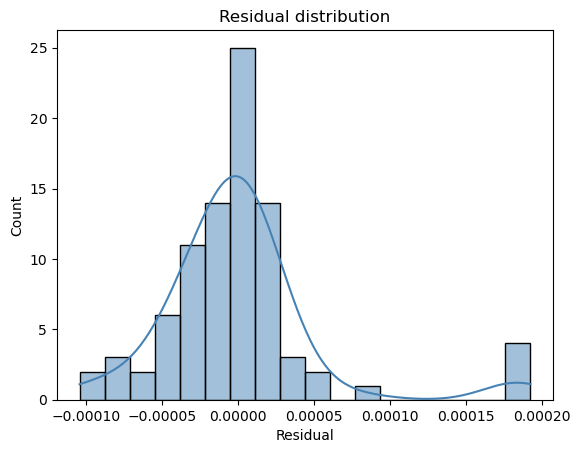

In [104]:
# Checking normality of residuals

sns.histplot(residual_1, kde=True, color="steelblue")
plt.xlabel("Residual")
plt.title("Residual distribution")
plt.show()

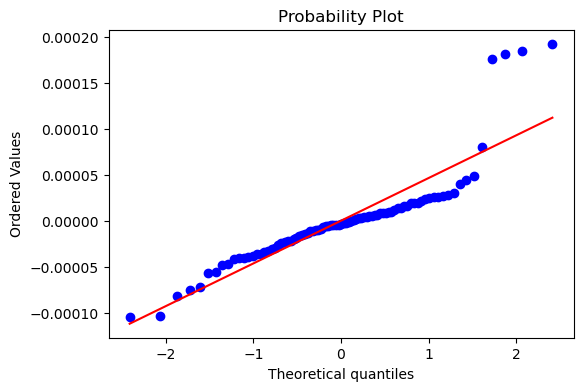

In [105]:
# QQ plot
fig, ax = plt.subplots(figsize=(6,4))
sp.stats.probplot(residual_1, plot=ax, fit=True)
plt.show()

In [106]:
# Shapiro-Wilk test for normality of residuals
statistic_1, p_value_1 = sp.stats.shapiro(residual_1)
print(statistic_1, p_value_1)

0.8043116927146912 2.1730253152441037e-09


In [107]:
# Durbin Watson test for auto-correlation
durbin_watson_statistic = sm.stats.durbin_watson(residual_1)
print(durbin_watson_statistic)

2.2195921841129613


Since the Durbin-Watson statistic value is around 2, it indicates that there is no significant autocorrelation in the residuals.

​

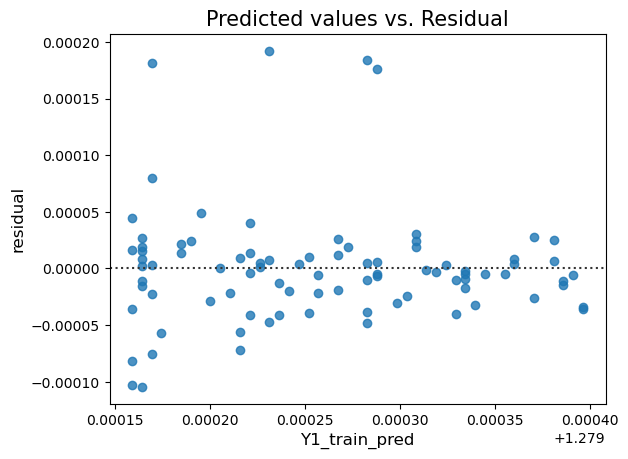

In [108]:
sns.residplot(x=Y1_train_pred, y=residual_1)
plt.xlabel("Y1_train_pred", fontsize = 12)
plt.ylabel("residual", fontsize = 12)
plt.title("Predicted values vs. Residual", fontsize=15)
plt.show()


In [109]:
# while True:
#     max_pvalue = model_1.pvalues.max()
    
#     if max_pvalue > 0.05:
#         feature_to_remove = model_1.pvalues.idxmax()
#         X_1 = X_1.drop(columns=[feature_to_remove])
#         model_1 = sm.OLS(Y_1, X_1).fit()
        
#     else:
#         break

In [110]:
# print(model_1.summary())

# Model 2 : Smoker and BMI > 30 

In [111]:
X_2 = df_2.drop(columns = 'charges', axis=1)
Y_2 = df_2['charges']

X_2 = sm.add_constant(X_2)

model_2 = sm.OLS(Y_2, X_2).fit()

### Feature selection by backward elimination method 

In [112]:
while True:
    max_pvalue = model_2.pvalues.max()
    
    if max_pvalue > 0.05:
        feature_to_remove = model_2.pvalues.idxmax()
        X_2 = X_2.drop(columns=[feature_to_remove])
        model_2 = sm.OLS(Y_2, X_2).fit()
        
    else:
        break   


In [113]:
print(model_2.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     1046.
Date:                Fri, 06 Oct 2023   Prob (F-statistic):          2.95e-104
Time:                        15:01:50   Log-Likelihood:                -1038.6
No. Observations:                 132   AIC:                             2091.
Df Residuals:                     125   BIC:                             2111.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age          267.9041      3.928     68.200      0.0

In [114]:
X_2.head()

,age,bmi,children,male,smokes,southeast,southwest
14,27,42.13,0,1,1,1,0
19,30,35.30,0,1,1,0,1
23,34,31.92,1,0,1,0,0
29,31,36.30,2,1,1,0,1
30,22,35.60,0,1,1,0,1


### BP test for homoscedasticity

In [115]:
_, bp_value, _, _ = sm.stats.diagnostic.het_breuschpagan(model_2.resid, X_2)
print(bp_value)

0.3570381822118177


Since p value > 0.05, Ho is not rejected, indicating evidence of homoscedaticity (ie. the variance of the residuals is constant)

## Fitting MLR on model 2 

#### Box cox transformation

In [116]:
df2_to_transform = Y_2
df2_transformed, lambda_2 = stats.boxcox(df2_to_transform) 
Y_2 = df2_transformed

In [117]:
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X_2, Y_2, test_size=0.2, random_state=5)


In [118]:
lr = LinearRegression()
lrmodel_2 = lr.fit(X2_train, Y2_train)

In [119]:
Y2_train_pred = lrmodel_2.predict(X2_train)
Y2_test_pred = lrmodel_2.predict(X2_test)

In [120]:
residual_2 = Y2_train - Y2_train_pred

In [121]:
print(lrmodel_2.coef_)

[ 4.92300409e-04  8.94139809e-04  9.28060374e-04 -9.76769631e-04
 -2.60208521e-18 -1.03298924e-03 -1.25211788e-03]


In [122]:
print(lrmodel_2.intercept_)

3.740595940626312


In [123]:
r2 = r2_score(Y2_train, Y2_train_pred)
adjr2 = 1-((1-r2)*131/124)

In [124]:
print("Training R^2 = ",r2)
print("Adjusted R^2 = ",adjr2)

Training R^2 =  0.9846593830813186
Adjusted R^2 =  0.9837933805133285


## Ridge regression model 

In [125]:
ridge_2 = Ridge()
ridge_2.fit(X2_train, Y2_train)
ridge_Y2_train_pred = ridge_2.predict(X2_train)
#ridge_r2_train = metrics.r2_score(Y_train, ridge_training_data_prediction)
print('ridge R^2 (train data) :', r2_score(Y2_train, ridge_Y2_train_pred))

ridge_Y2_test_pred = ridge_2.predict(X2_test)
#ridge_r2_test = metrics.r2_score(Y_test, ridge_testing_data_prediction)
print('ridge R^2 (test data) :', r2_score(Y2_test, ridge_Y2_test_pred))

ridge R^2 (train data) : 0.9846242327636467
ridge R^2 (test data) : 0.9912072734754476


### VIF test for multicollinearity 

In [126]:
# VIF test for multicollinearity
p = X2_train.shape[1]
print(p)

vif = [variance_inflation_factor(X2_train.values, i) for i in range(p)]
vif = pd.Series(vif, index = X2_train.columns)
print(vif)

7
age            1.049726
bmi            1.229717
children       1.072655
male           1.009231
smokes       132.459155
southeast      1.411034
southwest      1.214185
dtype: float64


VIF of all the regressor variables of the model are less than 5 indicating no multiollinearity.

### Durbin Watson test for auto-correlation 

In [127]:
durbin_watson_statistic = sm.stats.durbin_watson(residual_2)
print(durbin_watson_statistic)

1.5397698831750135


Since 1.5 < Durbin-Watson statistic value < 2.5, it indicates that there is no significant autocorrelation in the residuals.

### Checking normality of residuals 

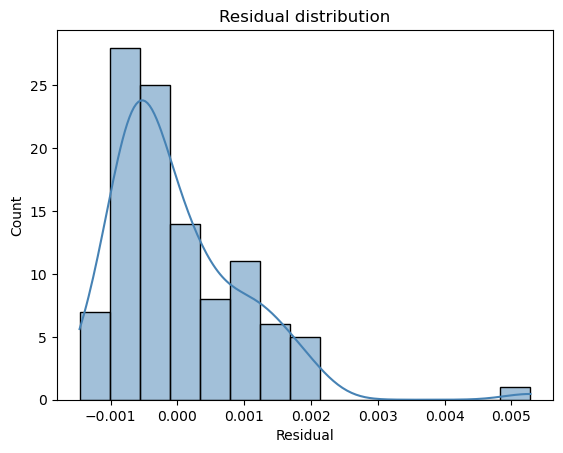

In [128]:
sns.histplot(residual_2, kde=True, color="steelblue")
plt.xlabel("Residual")
plt.title("Residual distribution")
plt.show()

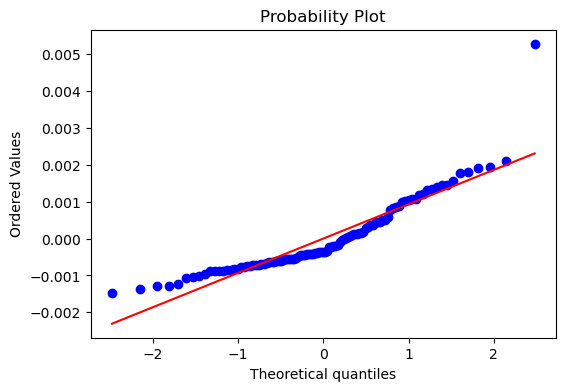

In [129]:
# QQ plot
fig, ax = plt.subplots(figsize=(6,4))
sp.stats.probplot(residual_2, plot=ax, fit=True)
plt.show()

In [130]:
# Shapiro-Wilk test for normality of residuals
statistic_2, p_value_2 = sp.stats.shapiro(residual_2)
print(statistic_2, p_value_2)

0.8611680269241333 1.7343424474347557e-08


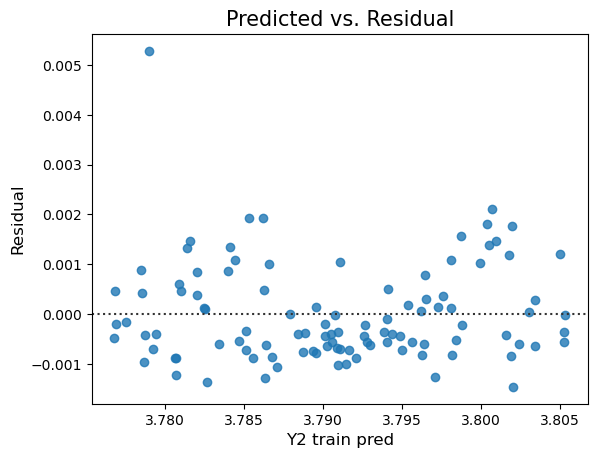

In [131]:
sns.residplot(x=Y2_train_pred, y=residual_2)
plt.xlabel("Y2 train pred", fontsize = 12)
plt.ylabel("Residual", fontsize = 12)
plt.title("Predicted vs. Residual", fontsize=15)
plt.show()

Points are mostly spread within a horizontal band in the above residual plot indicating presence of homoscedasticity (variance of residuals is constant)

### Feature selection by backward elimination method

In [132]:
# while True:
#     max_pvalue = model_2.pvalues.max()
    
#     if max_pvalue > 0.05:
#         feature_to_remove = model_2.pvalues.idxmax()
#         X_2 = X_2.drop(columns=[feature_to_remove])
#         model_2 = sm.OLS(Y_2, X_2).fit()
        
#     else:
#         break   
        


In [133]:
# print(model_2.summary())

#  Model 3 : Non Smokers

In [134]:
X_3 = df_3.drop(columns = 'charges', axis=1)
Y_3 = df_3['charges']

X_3 = sm.add_constant(X_3)

model_3 = sm.OLS(Y_3, X_3).fit()

In [135]:
while True:
    max_pvalue = model_3.pvalues.max()
    
    if max_pvalue > 0.05:
        feature_to_remove = model_3.pvalues.idxmax()
        X_3 = X_3.drop(columns=[feature_to_remove])
        model_3 = sm.OLS(Y_3, X_3).fit()
        
    else:
        break   
        


In [136]:

print(model_3.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     314.0
Date:                Fri, 06 Oct 2023   Prob (F-statistic):          7.09e-248
Time:                        15:01:52   Log-Likelihood:                -9383.2
No. Observations:                1013   AIC:                         1.878e+04
Df Residuals:                    1005   BIC:                         1.882e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3784.3945    482.843     -7.838      0.0

In [137]:
X_3.head()

,const,age,bmi,children,male,smokes,northwest,southeast,southwest
1,1.0,18,33.77,1,1,0,0,1,0
2,1.0,28,33.00,3,1,0,0,1,0
4,1.0,32,28.88,0,1,0,1,0,0
5,1.0,31,25.74,0,0,0,0,1,0
6,1.0,46,33.44,1,0,0,0,1,0


### BP test for homoscedasticity

In [138]:
_, bp_value, _, _ = sm.stats.diagnostic.het_breuschpagan(model_3.resid, X_3)
print(bp_value)

0.015936482501205315


In [139]:
# Attempted Box-Cox, logarithmic and square root transformation. Logarithmic Transformation gave results closest to normality 

# df3_to_transform = Y_3
# df3_transformed, lambda_3 = stats.boxcox(df3_to_transform) 
# Y_3 = df3_transformed

### Applying logarithmic Transformation 

In [140]:
Y_3 = np.log(Y_3)

In [141]:
# Y_3 = np.sqrt(Y_3)

In [142]:
Y_3 = (Y_3)

In [143]:
X3_train, X3_test, Y3_train, Y3_test = train_test_split(X_3, Y_3, test_size=0.2, random_state=5)


In [144]:
lr = LinearRegression()
lrmodel_3 = lr.fit(X3_train, Y3_train)

In [145]:
Y3_train_pred = lrmodel_3.predict(X3_train)
Y3_test_pred = lrmodel_3.predict(X3_test)

In [146]:
residual_3 = Y3_train - Y3_train_pred

In [147]:
print(lrmodel_3.coef_)

[ 0.00000000e+00  4.24902391e-02  5.88784139e-03  1.19832699e-01
 -9.31673555e-02 -5.55111512e-17 -1.08860292e-01 -2.19687874e-01
 -1.82795297e-01]


In [148]:
print(lrmodel_3.intercept_)

6.9173242996114155


In [149]:
r2 = r2_score(Y3_train, Y3_train_pred)
adjr2 = 1-((1-r2)*108/106)

In [150]:
print("Training R^2 = ",r2)
print("Adjusted R^2 = ",adjr2)

Training R^2 =  0.8300666772129577
Adjusted R^2 =  0.8268603881037682


In [151]:
ridge_3 = Ridge()
ridge_3.fit(X3_train, Y3_train)
ridge_Y3_train_pred = ridge_3.predict(X3_train)
#ridge_r2_train = metrics.r2_score(Y_train, ridge_training_data_prediction)
print('ridge R^2 (train data) :', r2_score(Y3_train, ridge_Y3_train_pred))

ridge_Y3_test_pred = ridge_3.predict(X3_test)
#ridge_r2_test = metrics.r2_score(Y_test, ridge_testing_data_prediction)
print('ridge R^2 (test data) :', r2_score(Y3_test, ridge_Y3_test_pred))

ridge R^2 (train data) : 0.8300618578495003
ridge R^2 (test data) : 0.8298714097673147


### VIF test for multicollinearity

In [152]:
# VIF test for multicollinearity
p = X3_train.shape[1]
print(p)

vif = [variance_inflation_factor(X3_train.values, i) for i in range(p)]
vif = pd.Series(vif, index = X3_train.columns)
print(vif)

9
const        37.842500
age           1.025816
bmi           1.104252
children      1.004325
male          1.003654
smokes             NaN
northwest     1.538791
southeast     1.640453
southwest     1.572139
dtype: float64


C:\Users\bitha\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [153]:
durbin_watson_statistic = sm.stats.durbin_watson(residual_3)
print(durbin_watson_statistic)

1.996059559148115


Since the Durbin-Watson statistic value is around 2, it indicates that there is no significant autocorrelation in the residuals.

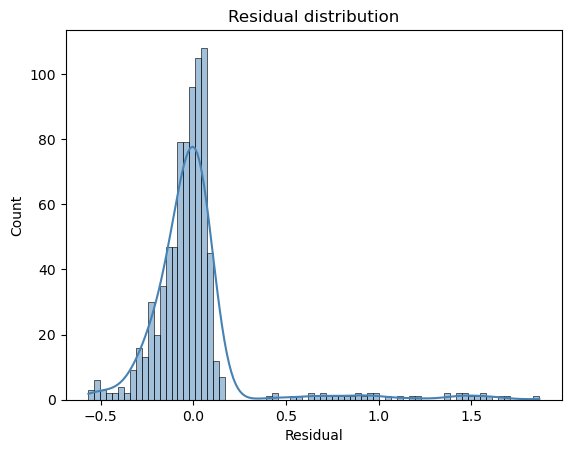

In [154]:
sns.histplot(residual_3, kde=True, color="steelblue")
plt.xlabel("Residual")
plt.title("Residual distribution")
plt.show()

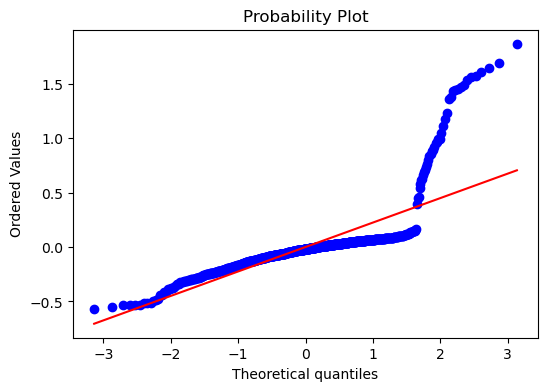

In [155]:
# QQ plot
fig, ax = plt.subplots(figsize=(6,4))
sp.stats.probplot(residual_3, plot=ax, fit=True)
plt.show()

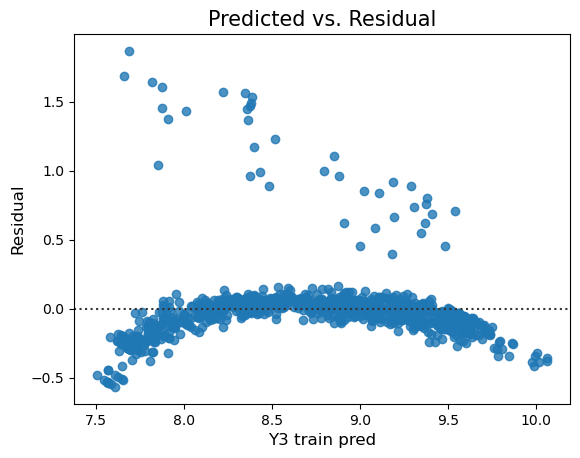

In [156]:
sns.residplot(x=Y3_train_pred, y=residual_3)
plt.xlabel("Y3 train pred", fontsize = 12)
plt.ylabel("Residual", fontsize = 12)
plt.title("Predicted vs. Residual", fontsize=15)
plt.show()

Points are mostly spread within a horizontal band in the above residual plot indicating presence of homoscedasticity (variance of residuals is constant)

In [157]:
# while True:
#     max_pvalue = model_3.pvalues.max()
    
#     if max_pvalue > 0.05:
#         feature_to_remove = model_3.pvalues.idxmax()
#         X_3 = X_3.drop(columns=[feature_to_remove])
#         model_3 = sm.OLS(Y_3, X_3).fit()
        
#     else:
#         break   
        

In [158]:
# print(model_3.summary())

In [160]:
import os
getcwd()

NameError: name 'getcwd' is not defined